#**Abdus Samad (DHC-474)**
#**Task 1**
#End-to-End ML Pipeline with Scikit-learn Pipeline API

# -------------------------
# 1) INSTALL & IMPORTS
# -------------------------

In [1]:
!pip install -q pandas scikit-learn joblib seaborn matplotlib

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

# -------------------------
# 2) LOAD DATASET
# -------------------------

In [3]:
from google.colab import files

uploaded = files.upload()

# file will be uploaded in current working directory
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

print("✅ Dataset Loaded Successfully")
print("Shape:", df.shape)
print(df.head())

Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn.csv
✅ Dataset Loaded Successfully
Shape: (7043, 21)
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4      

# -------------------------
# 3) DATA PREPROCESSING
# -------------------------

In [4]:
# Drop customerID (not useful)
df = df.drop("customerID", axis=1)

# Convert TotalCharges to numeric
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)

# Target variable
y = df["Churn"].map({"Yes": 1, "No": 0})
X = df.drop("Churn", axis=1)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Identify categorical & numerical columns
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

print("Categorical Columns:", categorical_cols)
print("Numerical Columns:", numerical_cols)

# Transformers
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# Combine into ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

Categorical Columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numerical Columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


/tmp/ipython-input-413746211.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)


# -------------------------
# 4) MODELS & PIPELINES
# -------------------------

In [5]:
log_reg_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])

# -------------------------
# 5) GRID SEARCH
# -------------------------

In [6]:
param_grid_lr = {
    "classifier__C": [0.1, 1.0, 10.0],
    "classifier__solver": ["liblinear", "lbfgs"]
}

param_grid_rf = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [None, 10, 20]
}

grid_lr = GridSearchCV(log_reg_pipeline, param_grid_lr, cv=3, scoring="accuracy", n_jobs=-1)
grid_lr.fit(X_train, y_train)

grid_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=3, scoring="accuracy", n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Best Logistic Regression Params:", grid_lr.best_params_)
print("Best Random Forest Params:", grid_rf.best_params_)

Best Logistic Regression Params: {'classifier__C': 0.1, 'classifier__solver': 'liblinear'}
Best Random Forest Params: {'classifier__max_depth': 10, 'classifier__n_estimators': 100}


# -------------------------
# 6) EVALUATION
# -------------------------


🔹 Logistic Regression Accuracy: 0.7991
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1035
           1       0.64      0.55      0.59       374

    accuracy                           0.80      1409
   macro avg       0.74      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409



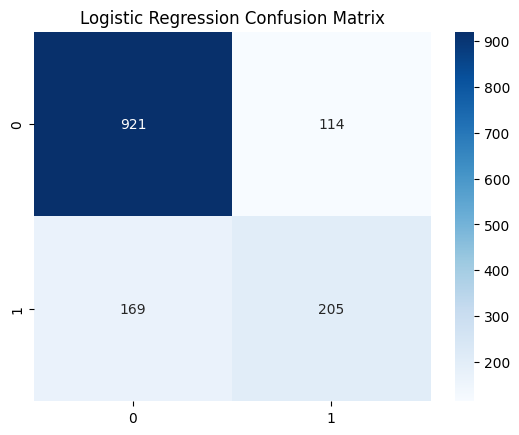


🔹 Random Forest Accuracy: 0.8027
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.66      0.53      0.59       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.79      0.80      0.80      1409



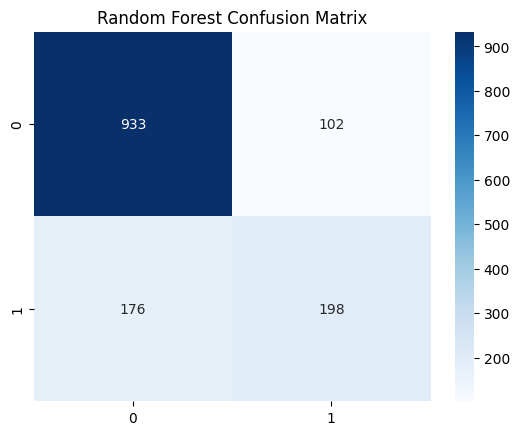

In [7]:
for model_name, model in [("Logistic Regression", grid_lr), ("Random Forest", grid_rf)]:
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n🔹 {model_name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

# -------------------------
# 7) EXPORT PIPELINE
# -------------------------

In [8]:
best_model = grid_rf if grid_rf.best_score_ > grid_lr.best_score_ else grid_lr
joblib.dump(best_model, "churn_pipeline.joblib")
print("✅ Best model pipeline saved as churn_pipeline.joblib")

✅ Best model pipeline saved as churn_pipeline.joblib
